<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Boosting Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

# Dictionary of file names and download links
files = {'Heart.csv':'https://storage.googleapis.com/aipi_datasets/Heart.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

We will be working with a dataset about 303 patients, including demographic data and physiological data collected for the study on each patient.  A full description of the dataset can be found at https://archive.ics.uci.edu/ml/datasets/heart+disease.

In [3]:
# Read in the data from csv
heart_df = pd.read_csv('Heart.csv',index_col=0)
# Clean up the dataframe
heart_df = heart_df.dropna()
heart_df['ChestPain'] = heart_df['ChestPain'].astype('category').cat.codes
heart_df['Thal']=heart_df['Thal'].astype('category').cat.codes
heart_df['AHD'] = (heart_df['AHD']=='Yes').astype(int)
heart_df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,3,145,233,1,2,150,0,2.3,3,0.0,0,0
2,67,1,0,160,286,0,2,108,1,1.5,2,3.0,1,1
3,67,1,0,120,229,0,2,129,1,2.6,2,2.0,2,1
4,37,1,1,130,250,0,0,187,0,3.5,3,0.0,1,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,1,0


In [4]:
X = heart_df.drop(labels='AHD',axis=1)
y = heart_df['AHD']

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.1)

## Baseline model - decision tree
Let's first get a baseline using a Decision Tree model

In [5]:
# Train the tree model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train,y_train)

# Calculate the accuracy on the test set
test_preds = tree_model.predict(X_test)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.700


## Random Forest
Now let's try a Random Forest and see how it performs relative to our single tree model

In [6]:
# Grid search to find optimal Random Forest hyperparameters
params = {'min_samples_leaf':[1,5,20],'n_estimators':[100,1000],
          'max_features':[0.1,0.5,1.],'max_samples':[0.5,None]}

model = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(model,params,cv=3)
grid_search.fit(X_train,y_train)

# Display the best parameters
grid_search.best_params_

{'max_features': 0.1,
 'max_samples': 0.5,
 'min_samples_leaf': 1,
 'n_estimators': 1000}

In [7]:
# Retrain the optimal model on full training set and calculate test set accuracy
opt_rf_model = RandomForestClassifier(**grid_search.best_params_,random_state=0)
opt_rf_model.fit(X_train,y_train)

# Calculate the accuracy on the test set
test_preds = opt_rf_model.predict(X_test)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.800


## AdaBoost
Let's set up a boosting model and see if we can beat our random forest model performance

In [8]:
# Train a boosting model on the dataset
boosting_model = AdaBoostClassifier(n_estimators=50,random_state=0)
boosting_model.fit(X_train,y_train)

# Calculate the accuracy on the test set
test_preds = boosting_model.predict(X_test)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.700


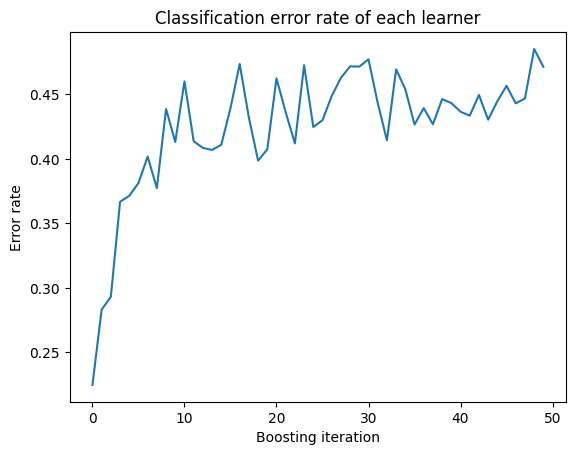

In [9]:
# View the errors of each weak learner
plt.plot(boosting_model.estimator_errors_)
plt.title('Classification error rate of each learner')
plt.xlabel('Boosting iteration')
plt.ylabel('Error rate')
plt.show()

In [10]:
# Try a boosting model using a logistic regression as the weak learner instead of a decision stump
boosting_model = AdaBoostClassifier(base_estimator=LogisticRegression(),
                                   n_estimators = 50, random_state=0)
boosting_model.fit(X_train,y_train)

# Calculate the accuracy on the test set
test_preds = boosting_model.predict(X_test)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.733


Our main hyperparameter in AdaBoost is the number of weak learners we want to include.  Let's try a range of values and see what number gives us the best performance

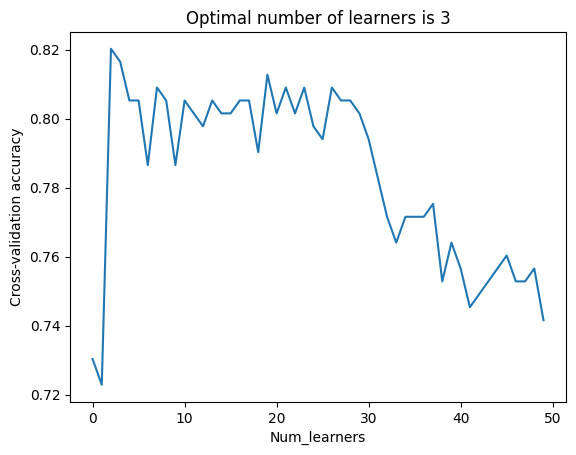

In [11]:
learners_range = range(1,51)
scores = []
for num in learners_range:
    boosting_model = AdaBoostClassifier(n_estimators=num,random_state=0)
    score = cross_val_score(boosting_model,X_train,y_train,scoring='accuracy',cv=3)
    scores.append(np.mean(score))
    
idx = np.argmax(scores)
opt_learners = learners_range[idx]

plt.plot(scores)
plt.xlabel('Num_learners')
plt.ylabel('Cross-validation accuracy')
plt.title('Optimal number of learners is {}'.format(opt_learners))
plt.show()

In [12]:
# Retrain optimal boosting model and get test set accuracy
opt_boosting_model = AdaBoostClassifier(n_estimators=opt_learners,random_state=0)
opt_boosting_model.fit(X_train,y_train)

test_preds = opt_boosting_model.predict(X_test)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print("Accuracy on the test set is {:.3f}".format(test_acc))

Accuracy on the test set is 0.833


## Gradient boosting
An alternative boosting algorithm to AdaBoost is Gradient Boosting.  In Gradient Boosting, we train multiple decision tree learners on the residuals of the previous learners and combine the outputs of all learners together (each multiplied by the learning rate) to make the predictions.

In [13]:
# Grid search to find optimal hyperparameters
params = {'min_samples_leaf':[1,5,10],'n_estimators':[5,10,20,50],
          'max_features':[0.1,0.5,1.]}

gb_model = GradientBoostingClassifier(random_state=0)
grid_search = GridSearchCV(gb_model,params,cv=3)
grid_search.fit(X_train,y_train)

# Display the best parameters
grid_search.best_params_


{'max_features': 0.1, 'min_samples_leaf': 10, 'n_estimators': 20}

In [14]:
# Retrain the optimal model on full training set and calculate test set accuracy
opt_gb_model = GradientBoostingClassifier(**grid_search.best_params_,random_state=0)
opt_gb_model.fit(X_train,y_train)

# Calculate the accuracy on the test set
test_preds = opt_gb_model.predict(X_test)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.800


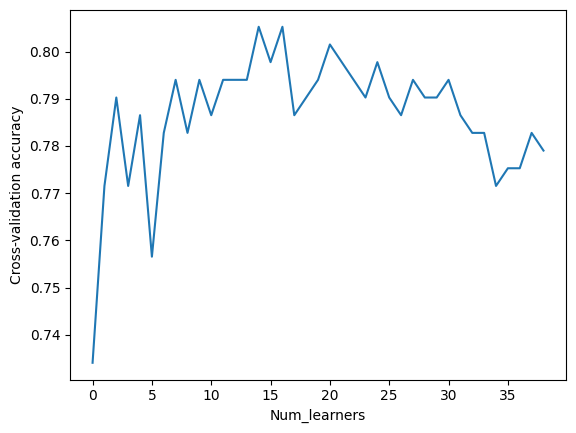

In [15]:
# Let's look at how accuracy changes as we increase number of learners
learners_range = range(1,40)
scores = []
for num in learners_range:
    boosting_model = GradientBoostingClassifier(n_estimators=num,random_state=0)
    score = cross_val_score(boosting_model,X_train,y_train,scoring='accuracy',cv=3)
    scores.append(np.mean(score))
    
idx = np.argmax(scores)
opt_learners = learners_range[idx]

plt.plot(scores)
plt.xlabel('Num_learners')
plt.ylabel('Cross-validation accuracy')
#plt.title('Optimal number of learners is {}'.format(opt_learners))
plt.show()

## Ensemble model approaches
Now let's combine a few classifiers together into an ensemble.

In [16]:
# Use 'hard' voting: use majority vote across discrete predictions of each model
ensemble_model = VotingClassifier(estimators=[('rf',opt_rf_model),
                                             ('ada',opt_boosting_model),
                                             ('logreg',LogisticRegression())],
                                  voting='hard')

ensemble_model.fit(X_train,y_train)

test_preds = ensemble_model.predict(X_test)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print("Accuracy on the test set is {:.3f}".format(test_acc))

Accuracy on the test set is 0.833


In [17]:
# Use 'soft' voting: use argmax across sum of probabilistic predictions from each model
ensemble_model = VotingClassifier(estimators=[('rf',opt_rf_model),
                                             ('ada',opt_boosting_model),
                                             ('logreg',LogisticRegression())],
                                 voting='soft')

ensemble_model.fit(X_train,y_train)

test_preds = ensemble_model.predict(X_test)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print("Accuracy on the test set is {:.3f}".format(test_acc))

Accuracy on the test set is 0.800


In [18]:
# Use 'soft' weighted voting
ensemble_model = VotingClassifier(estimators=[('rf',opt_rf_model),
                                             ('ada',opt_boosting_model),
                                             ('logreg',LogisticRegression())],
                                 voting='soft',
                                 weights = [1,2,1])

ensemble_model.fit(X_train,y_train)

test_preds = ensemble_model.predict(X_test)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print("Accuracy on the test set is {:.3f}".format(test_acc))

Accuracy on the test set is 0.833


In [19]:
# Use StackingClassifier - fit final estimator to combine 3 members optimally
stacking_model = StackingClassifier(estimators=[('rf',opt_rf_model),
                                             ('ada',opt_boosting_model),
                                             ('logreg',LogisticRegression())],
                                 final_estimator=LogisticRegression(),
                                 cv=3)

stacking_model.fit(X_train,y_train)

test_preds = ensemble_model.predict(X_test)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print("Accuracy on the test set is {:.3f}".format(test_acc))

Accuracy on the test set is 0.833
